# Surface-grid operations

Here, we will discuss the various surface-grid operators available in the package.
We will start by generating the cache, just as we did in Immersed layer caches

In [1]:
using ImmersedLayers
using Plots
using LinearAlgebra

### Set up the grid, shape, and cache
We do this just as we did in Immersed layer caches

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx)
RadC = 1.0
Δs = 1.4*cellsize(g)
body = Circle(RadC,Δs)
cache = SurfaceScalarCache(body,g,scaling=GridScaling)

Surface cache with scaling of type GridScaling
  448 point data of type ScalarData{448, Float64, Vector{Float64}}
  Grid data of type Nodes{Primal, 408, 408, Float64, Matrix{Float64}}


## Basic regularization and interpolation
Let's perform an example in which we regularize the x coordinate of
the surface points onto the grid. We can get the surface coordinates
by using the `points` function. This can be applied either to
`body` directly or to the `cache`. As for any `VectorData` type, the components
of `pts` are `pts.u` and `pts.v`.

In [3]:
pts = points(cache);

Now, we set up some blank grid data on which to regularize onto

In [4]:
gx = zeros_grid(cache);

Now regularize. We will time it to show that it is fast and memory-efficient:

In [5]:
regularize!(gx,pts.u,cache) #hide
@time regularize!(gx,pts.u,cache);

  0.000064 seconds (2 allocations: 48 bytes)


Let's plot this to look at it. This also gives us a chance to highlight
the plot recipe for grid data associated with the cache, which is achieved by
simply supplying the cache to the `plot` function in `Plots.jl`. By default,
this plots the immersed points, as well, but this can be suppressed by
adding the keyword `layers=false`.

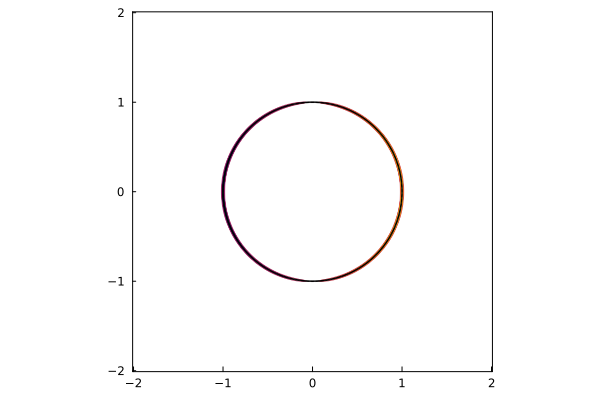

In [6]:
plot(gx,cache)

This shows how the regularization spreads the data over a couple of cells
around the surface. In the parlance of potential theory, this is a **single layer**.
If we wish to interpolate, then we do so with the [`interpolate!`]
function. For example, suppose we have a uniform field that we wish to interpolate:

In [7]:
oc = 2.5*ones_grid(cache)

Nodes{Primal, 408, 408, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
407×407 Matrix{Float64}:
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  …  2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5  …  2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 2.5  2.5  2.5  2.5  2.5  2.5  2.5  2.5     2.5  2.5  2.5  2.5  2.5  2.5  2.5
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 2.5  2.5  2.5

Now set up some surface data to receive the interpolated data, and
interpolate:

In [8]:
f = zeros_surface(cache);
interpolate!(f,oc,cache)

448 points of scalar-valued Float64 data
448-element Vector{Float64}:
 2.5000000000000004
 2.5
 2.4999999999999982
 2.4999999999999987
 2.5
 2.499999999999998
 2.4999999999999987
 2.4999999999999982
 2.4999999999999987
 2.4999999999999987
 ⋮
 2.499999999999999
 2.4999999999999996
 2.4999999999999987
 2.4999999999999987
 2.4999999999999982
 2.499999999999999
 2.499999999999999
 2.499999999999999
 2.4999999999999996

It is clear that the interpolation preserves the value of the
field. This is also true for linearly varying fields, since the DDF
is built to ensure this. Let's try this, using the $x$ coordinate of the grid. Here, we use the `coordinates`
function of `CartesianGrids.jl`, which gets the coordinates of the grid,
and set the values of grid data to the $x$ coordinate. We interpolate and plot,
comparing to the actual $x$ coordinate of the points on the body:

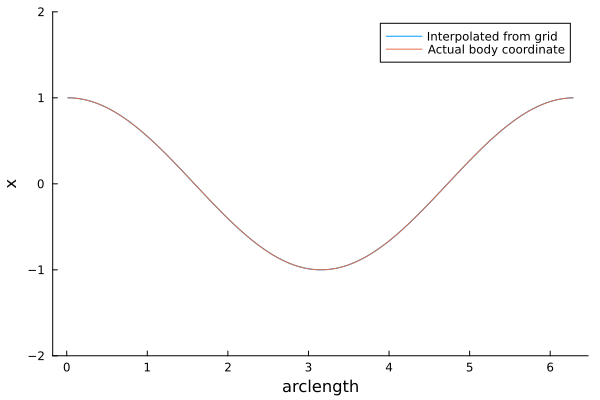

In [9]:
xg = x_grid(cache)
interpolate!(f,xg,cache)
plot(f,cache,ylim=(-2,2),label="Interpolated from grid",ylabel="x",xlabel="arclength")
plot!(pts.u,cache,label="Actual body coordinate",legend=:true)

## A double layer
Now we will generate a double layer. Mathematically, this takes the form

$$D_s f = \nabla\cdot \left( \delta(\chi) \mathbf{n} f \right)$$

for some scalar data $f$ on the surface. (See Background for an example.)
Notice that it maps scalar data on the surface ($f$) to scalar data in space. So to
calculate this using our discrete tools, we set up some grid data to receive the
result. Then, we use the function `surface_divergence!` to compute the
double layer. Here, we will demonstrate this on the $y$ coordinate of the
surface points:

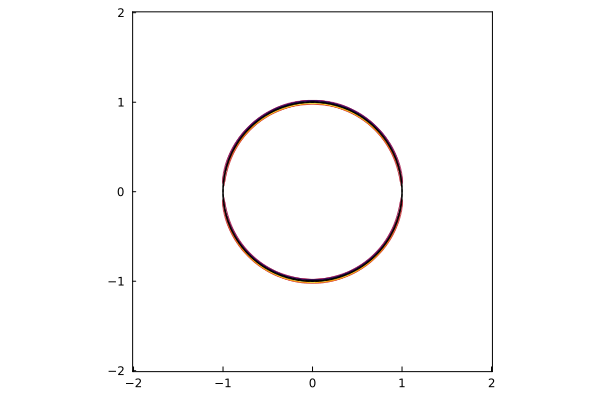

In [10]:
dl = zeros_grid(cache)
surface_divergence!(dl,pts.v,cache)
plot(dl,cache)

If the surface data are vectors, $\mathbf{f}$, then this operation is a little
different:

$$D_s \mathbf{f} = \nabla\cdot \left[\delta(\chi) \left(  \mathbf{n} \mathbf{f} + \mathbf{f} \mathbf{n} \right) \right]$$

This maps $\mathbf{f}$ to a vector field. We use this in conjunction with a cache
generated with `SurfaceVectorCache`.

The transpose of the double layer, $D_s$, is the operation

$$G_s u = \mathbf{n}\cdot \delta^{T}(\chi) \nabla u$$

for some scalar field data $u$. This operation computes the gradient of the field
data, interpolates this gradient onto the surface, and obtains the normal
component of that surface data. As such, it represents an important tool
for computing the normal derivative of field data on a surface. In the
package, we use `surface_grad!` for this operation.

The vector field version of this is

$$G_s \mathbf{u} = \mathbf{n}\cdot \delta^{T}(\chi) (\nabla \mathbf{u} + \nabla^{T} \mathbf{u})$$

which maps vector field data $\mathbf{u}$ to vector-valued surface data.

## A curl layer
We also sometimes need to take the curl of the regularized surface data,

$$C_s f = \nabla\times \left( \delta(\chi) \mathbf{n} f \right)$$

For this, we use the `surface_curl!` operator. Let's demonstrate this
on a uniform field on the surface.

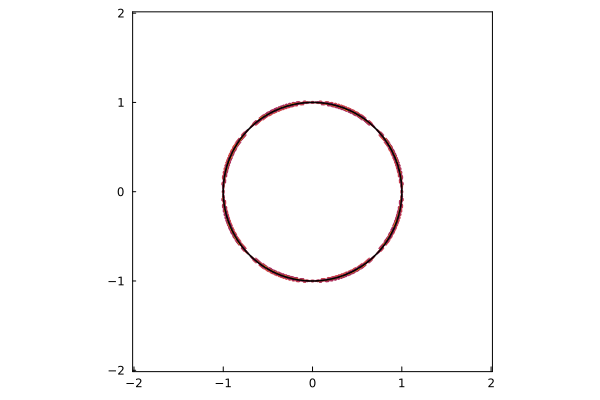

In [11]:
gc = zeros_gridcurl(cache)
f = ones_surface(cache)
surface_curl!(gc,f,cache)
plot(gc,cache)

The continuous version of this operation is actually zero. It's not quite
zero in discrete form. However, its norm is much smaller than that of
the double layer.

In [12]:
norm(gc,cache)/norm(dl,cache)

0.05670933567126697

Finally, a pair of operations that are used in support of the
previous ones, or occasionally on their own, are

$$R_n f = \delta(\chi)\mathbf{n}\circ f$$

for scalar surface data $f$, which maps to a vector field, effectively a
field of doublet strengths; and its transpose

$$R_n^T \mathbf{u} = \mathbf{n}\cdot \delta^{T}(\chi)\mathbf{u}$$

which maps vector field data $\mathbf{u}$ to a scalar surface field, the normal
component of the vector field on the surface. These are
provided by `regularize_normal!` and `normal_interpolate!`,
respectively.

## Masks
Masks are grid data that take the value 1 in one region (e.g., the interior of a surface)
and 0 in the other (e.g., the exterior). The functions `mask`
and `complementary_mask` achieve this

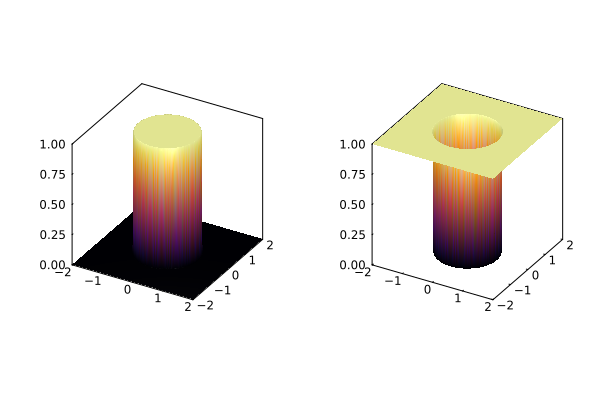

In [13]:
m = mask(cache)
cm = complementary_mask(cache)
plot(
   surface(m,cache,layers=false),
   surface(cm,cache,layers=false)
   )

One can apply a mask to some grid data by multiplying it, using, e.g.,
the `product!` function in `CartesianGrids.jl`. Let's demonstrate that
with the grid data of $x$ coordinates:

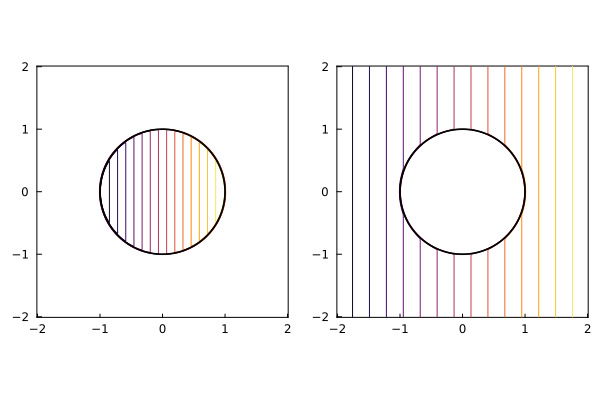

In [14]:
xmask = zeros_grid(cache)
xcmask = zeros_grid(cache)
product!(xmask,xg,m)
product!(xcmask,xg,cm)
plot(
 plot(xmask,cache),
 plot(xcmask,cache)
 )

The mask and complementary mask effectively partition the field into two parts.
We can also apply masks in place, using `mask!` and `complementary_mask!`:

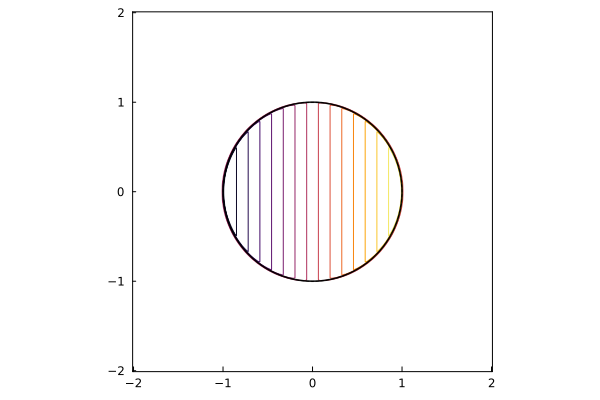

In [15]:
xmask .= xg
mask!(xmask,cache)
plot(xmask,cache)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*